<a href="https://colab.research.google.com/github/MLValadares/98345-course-uge/blob/main/02_Trip_generation_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

import sklearn.linear_model

import matplotlib.pyplot as plt
%matplotlib inline

# Trip generation

The purpose of this notebook is to give the student a basic understand of how a growth-factor-based trip generation model works and how it can be applied to data.

First, let's load the population, commuting, and municipality data from the last exercise:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/course-uge

/content/drive/MyDrive/Colab Notebooks/course-uge


In [ ]:
df_population = pd.read_parquet("data/population.parquet")
df_commutes = pd.read_parquet("data/commutes.parquet")
df_munipalities = gpd.read_parquet("data/municipalities.parquet")

**Task**: To reduce the amount of computation, filter all three data sets for the Île-de-France region. For the commuting data, make sure to only keep movements where both origin and destination are within the region.

In [ ]:
idf_departments = ["75", "92", "93", "94", "95", "77", "91", "78"]

In [ ]:
df_population.head()

,municipality_id,population,csp_1,csp_2,csp_3,csp_4,csp_5,csp_6,csp_7,csp_8
0,01001,619.406049,15.565978,19.822632,76.142088,98.357964,100.516361,126.843164,152.541469,29.616393
1,01002,205.408895,0.000000,21.265503,15.927908,26.460181,42.135589,10.596822,67.296631,21.726261
2,01004,11508.832532,2.762881,327.166403,784.225660,1890.243930,1891.133347,2001.750487,2763.422684,1848.127141
3,01005,1390.384400,4.913019,112.999439,112.999439,221.085859,294.781145,186.694725,338.998316,117.912458
4,01006,91.636364,0.000000,0.000000,5.090909,25.454545,15.272727,15.272727,25.454545,5.090909


In [ ]:
# Insert your code here
df_population = df_population[df_population["municipality_id"].str.startswith(tuple(idf_departments))]
df_munipalities = df_munipalities[df_munipalities["municipality_id"].str.startswith(tuple(idf_departments))]
df_commutes = df_commutes[df_commutes["origin_id"].str.startswith(tuple(idf_departments)) &
                          df_commutes["destination_id"].str.startswith(tuple(idf_departments))]

In [ ]:
df_commutes.head()

,origin_id,destination_id,weight
698478,75101,75101,3179.161525
698479,75101,75102,363.425022
698480,75101,75103,68.745733
698481,75101,75104,113.951745
698482,75101,75105,83.242573


## Simple model

**Task**: Implement the simple trip generation model as described during the lecture:

$$
O_i = \beta N_i
$$

with $O_i$ indicating the outflow (the number of commuters) of a municipality and $N_i$ its population count. To estimate, $\beta$, the following formula has been established:

$$
\beta = \frac{\sum_i \hat O_i \cdot N_i}{\sum_i N_i^2}
$$

with $\hat O_i$ as the reference commuters known from data.

In [ ]:
# Hint: Working with multiple data frames is easier if we know that the order with respect to the keys is the same. We can do so by indexing our data sets:
municipalities = df_munipalities["municipality_id"].unique()

df_population = df_population.set_index("municipality_id").reindex(municipalities)

In [ ]:
# Insert your code here

df_origins = df_commutes.groupby("origin_id")["weight"].sum().reset_index()
df_origins = df_origins.set_index("origin_id").reindex(municipalities)
df_origins.head()

O = df_origins["weight"].values # you only want the flow from the origns
N = df_population["population"].values

nominator = np.sum(O * N)
denominator = np.sum(N**2)

nominator, denominator

beta = nominator / denominator
beta

0.5531614269533764

**Task**: Generate the flows using your model.

In [ ]:
# Insert your code here

O_generated = beta * N
O_generated


array([ 7826.17862742, 10485.47458118, 16676.37743285, ...,
       11584.15492146,    88.50582831,   160.74914337])

**Task**: Plot the fit of your model as a scatter plot (x = reference, y = model).

Text(0, 0.5, 'Model')

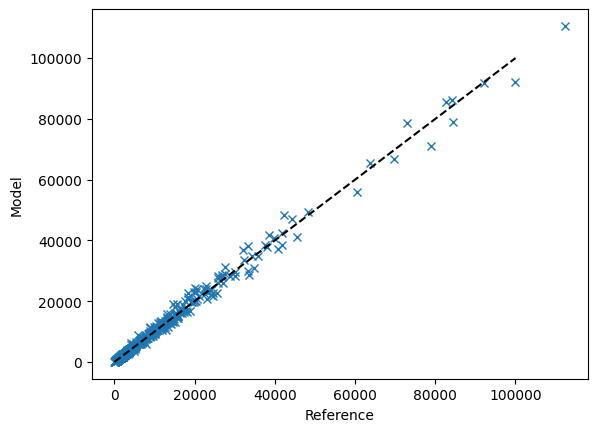

In [ ]:
# Insert your code here
plt.plot(O, O_generated, "x")
plt.plot([0, 100000], [0, 100000], "k--")
plt.xlabel("Reference")
plt.ylabel("Model")

## CSP Model

**Task**: Implement the CSP-based growth model for trip distribution as it was introduced in the lecture.

- Prepare the input data and reference data
- Set up the model
- Show the coefficients and the offset
- What do you observe? Which impact do individual CSP have on the commutes?

Hint: Make use of `sklearn.linear_model.LinearRegression`

In [ ]:
df_population.head()

,population,csp_1,csp_2,csp_3,csp_4,csp_5,csp_6,csp_7,csp_8
municipality_id,,,,,,,,,
75101,14148.091761,8.219674,858.482574,4539.964151,1836.291785,1488.190288,473.571426,2595.369864,2348.001999
75102,18955.541855,5.794080,1118.387492,7495.073734,2938.076049,2087.738607,755.340909,2139.595643,2415.535341
75103,30147.397523,0.000000,1681.731888,10884.185943,4689.087838,3050.944542,834.942053,4538.600484,4467.904777
75104,25655.441386,9.301578,1298.542305,8398.581660,3745.753317,2786.955909,677.409856,4466.380306,4272.516454
75105,51493.718545,9.852432,1949.135156,16721.625324,5921.875817,4009.463485,1112.417454,10496.187055,11273.161823


In [ ]:
# Insert your code here

# Set up the model input data (features)
# population
# X = df_population["population"].values
X = df_population.reindex(municipalities).values[:,1:]

# Set up the reference data (labels / ground truth)
# y = df_origins["weight"].values
y = df_origins.reindex(municipalities)["weight"].values

# Set up the sklearn model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)


LinearRegression()

**Task**: Apply the model to the population data without using sklearn, but just making use of the parameters. Show the fit with the reference data

Text(0, 0.5, 'Model')

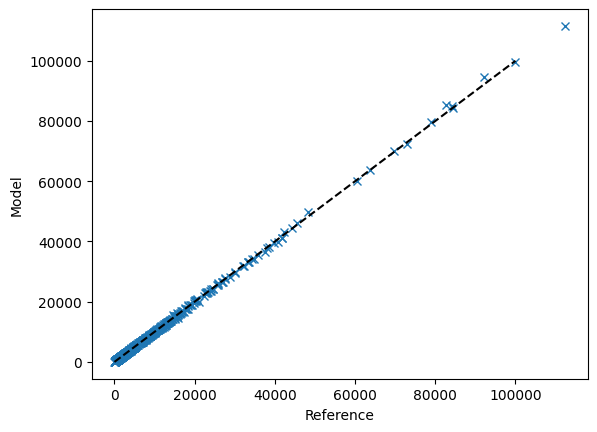

In [ ]:
# Insert your code here

# coefficients =
# intercept =

prediction = model.predict(X)

plt.plot(y, prediction, "x")
plt.plot([0, 100000], [0, 100000], "k--")
plt.xlabel("Reference")
plt.ylabel("Model")


**Bonus task:** Now we have a model that generates the number of outgoing commuters per day, based on the composition of the population in a zone. As a bonus task, go back to the population data from the previous task. Remember that it gave us the number of people in a CSP per IRIS, not only per municipality. Use the model that we have estimated now to generate the number of commuters per IRIS in Île-de-France.

In [ ]:
# Insert your code here
df_iris = gpd.read_file("data/CONTOURS-IRIS.shp")
df_iris = df_iris[["INSEE_COM", "CODE_IRIS", "geometry"]].rename(columns = {
    "INSEE_COM": "municipality_id", "CODE_IRIS": "iris_id"
})

df_iris_population = pd.read_csv("data/base-ic-evol-struct-pop-2019.CSV", sep = ";", dtype = {
    "IRIS": "str"
}, usecols = ["IRIS"] + ["C19_POP15P_CS{}".format(k) for k in range(1,9)])

renamed_columns = ["iris_id"]
renamed_columns += ["csp_{}".format(k) for k in range(1, 9)]

df_iris_population.columns = renamed_columns

**Congratulations**, you can now solve Exercise 2.1 and 2.2 of the course project.